In [1]:
import os
os.chdir('..')

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import gm
import dill
import gzip
from pathlib import Path
import importlib
from src.data import get_gwi, get_cmip6, sample_glaciers_from_gcms, get_rgi, get_cmip6_run_attrs, get_cmip6_lm, sample_glaciers, get_lmr
import src.data as data
from src.flowline import get_flowline_geom
from src.climate import detrend_gcm, extend_ts, prepend_ts
import xarray as xr
import multiprocess as mp
from itertools import product
from src.util import dict_key_from_value

In [3]:
import config

importlib.reload(config)
from config import cfg, ROOT


def temp_stable(yr):
    return 0


rgiid = list({k: v for k, v in cfg['glaciers'].items() if v['name'] == 'Argentiere'}.keys())[0]
params = cfg['glaciers'][rgiid]['flowline_params']

print(params)

{'ss.T0': 20.9, 'ss.noise.T0': 20.86, 'P0': 2, 'sigP': 0.55, 'sigT': 0.8, 'sigb': 0.71, 'L0': {'value': 10283, 'year': 1847, 'source': 'Leclerq'}, 'ss.noise.s_ba.profile': 'features/flowline/flowline2d_RGI60-11.03638.ss.noise.s_ba.pickle'}


In [4]:
rgi = get_rgi(rgiid, from_sqllite=True)
geom = get_flowline_geom(rgiid)

C:\sandbox\glacier-attribution\src\flowline.py:46: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  fl, inv, dsl = pickle.load(openfile)
C:\sandbox\glacier-attribution\src\flowline.py:50: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  mfl = pickle.load(openfile)


In [5]:
lmr = get_lmr()
lmr_rgi = sample_glaciers(lmr, rgi, as_dim=True)

df = lmr_rgi.to_dataframe().reset_index().dropna(how='any')

# use random precip instead of LMR precip
random_climate = pd.read_csv(Path(ROOT, r"features\ClimateRandom.csv"))
# df['prate'] = random_climate['P'].iloc[0:len(df)]

df = df.loc[:, [col for col in df.columns if col not in ['latitude', 'longitude', 'rgiid']]]
df = df.set_index(df.time.astype(int))
# ref0, ref1 = (1850, 1900)
ref0, ref1 = (1750, 1850)
Tref = df['air'].loc[ref0:ref1].mean()
Pref = df['prate'].loc[ref0:ref1].mean()
fp = Path(ROOT, params['ss.noise.s_ba.profile'])
with open(fp, 'rb') as f:
    last_run = dill.load(f)
    h_init = last_run.h.mean(axis=0)
    x_init = last_run.x

C:\sandbox\glacier-attribution\src\data.py:626: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xys = glaciers.geometry.centroid


In [6]:
df = df.reset_index(drop=True)
df = df.groupby('time').mean()
print(df)

      MCrun     prate       air
time                           
0       9.5 -0.009103 -0.159772
1       9.5 -0.003464 -0.175651
2       9.5 -0.008995 -0.353613
3       9.5 -0.000837 -0.441594
4       9.5  0.000601 -0.260409
...     ...       ...       ...
1996    9.5  0.043348  0.252100
1997    9.5  0.062994  0.542900
1998    9.5  0.035524  1.061794
1999    9.5 -0.001978  0.852001
2000    9.5 -0.026292  0.868560

[2001 rows x 3 columns]


# Adding variability to LMR so it equals sigT and sigP

In [8]:
t0 = 850
T = df['air'].iloc[850:]
sig_adj = np.sqrt(params['sigT']**2 - T.std()**2)
#sig_adj = params['sigT']
T = T - Tref
T = T + random_climate['T'] * sig_adj
T = T.dropna()

P = df['prate'].iloc[850:]
sig_adj = np.sqrt(params['sigP']**2 - P.std()**2)
#sig_adj = params['sigP']
P = P - Pref
P = P + random_climate['P'] * sig_adj
P = P.dropna()

fig, ax = plt.subplots(2, 1)
ax[0].plot(T.rolling(30).mean())
ax[1].plot(P.rolling(30).mean())

model = gm.flowline2d(x_gr=geom.x, zb_gr=geom.zb, x_geom=geom.x, w_geom=geom.w, x_init=x_init,
                      h_init=h_init, xmx=geom.x.max(),
                      temp=temp_stable, sigT=params['sigT'], sigP=params['sigP'], P0=params['P0'],
                      delt=0.0125 / 32, delx=50,
                      ts=int(T.index[0]), tf=int(T.index[-1]), T0=params['ss.noise.T0'],
                      T=T, P=P,
                      rt_plot=False, dt_plot=20)
model.Tref = Tref  # additional variable to save for later analysis
model.Pref = Pref
model.ref_period = (ref0, ref1)

fig = model.plot()
fig.suptitle(f'{rgiid} LMR ensemble grand mean')
#fig_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.Pnoise.{nrun}.png')
fig_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.gmean.red_noise_test.filled_red.png')
fig.savefig(fig_output_name)

# file_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.Pnoise.{nrun}.pickle')
file_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.gmean.red_noise_test.filled_red.pickle')
model.to_pickle(file_output_name)

100%|#######################################################| 1150.0/1150.0 [00:32<00:00, 35.16yrs/s


<Figure size 1800x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Only original LMR precipitation variability, no temperature variability

In [10]:
t0 = 850
T = df['air'].iloc[850:]
T = T * 0

P = df['prate'].iloc[850:]
sig_adj = np.sqrt(params['sigP']**2 - P.std()**2)
#sig_adj = params['sigP']
P = P - Pref
P = P.dropna()

fig, ax = plt.subplots(2, 1)
ax[0].plot(T.rolling(30).mean())
ax[1].plot(P.rolling(30).mean())

model = gm.flowline2d(x_gr=geom.x, zb_gr=geom.zb, x_geom=geom.x, w_geom=geom.w, x_init=x_init,
                      h_init=h_init, xmx=geom.x.max(),
                      temp=temp_stable, sigT=params['sigT'], sigP=params['sigP'], P0=params['P0'],
                      delt=0.0125 / 32, delx=50,
                      ts=int(T.index[0]), tf=int(T.index[-1]), T0=params['ss.noise.T0'],
                      T=T, P=P,)
model.Tref = Tref  # additional variable to save for later analysis
model.Pref = Pref
model.ref_period = (ref0, ref1)

fig = model.plot()
fig.suptitle(f'{rgiid} LMR ensemble grand mean')
#fig_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.Pnoise.{nrun}.png')
fig_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.gmean.red_noise_test.only_p.png')
fig.savefig(fig_output_name)

# file_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.Pnoise.{nrun}.pickle')
file_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.gmean.red_noise_test.only_p.pickle')
model.to_pickle(file_output_name)

100%|#######################################################| 1150.0/1150.0 [00:30<00:00, 38.30yrs/s


<Figure size 1800x1000 with 0 Axes>

Figure(1800x1000)


C:\Users\drotto\AppData\Local\Temp\ipykernel_45824\430517207.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

100%|#######################################################| 1150.0/1150.0 [00:27<00:00, 41.18yrs/s


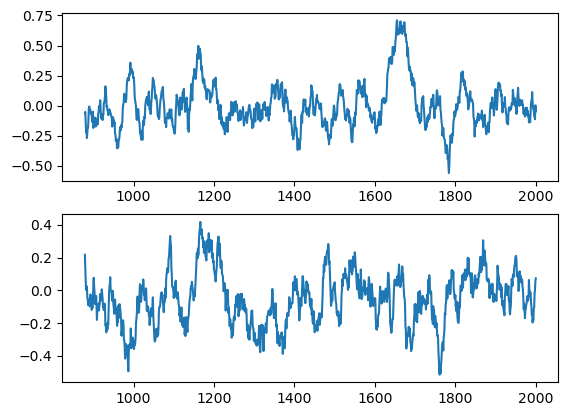

<Figure size 1800x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
t0 = 850
T = random_climate['T'].iloc[850:2001]
P = random_climate['P'].iloc[850:2001]

fig, ax = plt.subplots(2, 1)
ax[0].plot(T.rolling(30).mean())
ax[1].plot(P.rolling(30).mean())

model = gm.flowline2d(x_gr=geom.x, zb_gr=geom.zb, x_geom=geom.x, w_geom=geom.w, x_init=x_init,
                      h_init=h_init, xmx=geom.x.max(),
                      temp=temp_stable, sigT=params['sigT'], sigP=params['sigP'], P0=params['P0'],
                      delt=0.0125 / 32, delx=50,
                      ts=int(T.index[0]), tf=int(T.index[-1]), T0=params['ss.noise.T0'],
                      T=T, P=P,)
model.Tref = Tref  # additional variable to save for later analysis
model.Pref = Pref
model.ref_period = (ref0, ref1)

fig = model.plot()
fig.suptitle(f'{rgiid} LMR ensemble grand mean')
#fig_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.Pnoise.{nrun}.png')
fig_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.gmean.red_noise_test.white_noise.png')
fig.savefig(fig_output_name)

# file_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.Pnoise.{nrun}.pickle')
file_output_name = Path(ROOT, f'flowline2d_{rgiid}.lmr.gmean.red_noise_test.white_noise.pickle')
model.to_pickle(file_output_name)

0.7570093810474178
0.24637219984173742


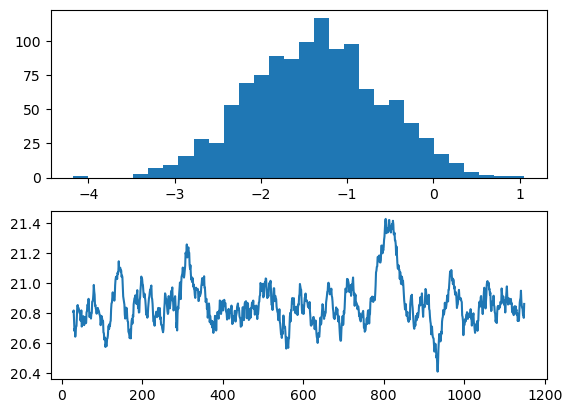

In [33]:
fig, ax = plt.subplots(2, 1)
b = np.nanmean(model.b, axis=-1)
ax[0].hist(b, bins=30)
ax[1].plot(pd.Series(model.T).rolling(30).mean())

print(b.std())
print(pd.Series(b).rolling(30).mean().std())